# NN - PHYS 555 Term Project - Sam and Breanna

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay

from custom_dataloader import replicate_data
from NN_Defs import get_n_params, train, validate, BaseMLP

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Running on : {device}')

Running on : cpu


## Importing Data and Creating Train/Validate/Testing Sets

In [29]:
# data load
X = np.load("Data/Input_Class_AllClasses_Sep.npy") # Load input data
Y = np.load("Data/Target_Class_AllClasses_Sep.npy") # Load target data

In [99]:
# custom data loader to pull in custom sized data set
# use seed to get replicable results for now
seed_val = 1111

# the amounts here are how many of each class of object you want in the training set and validation set
# leftover amount get's dumped into testing set

#amounts_train = [331,1141,231,529,27,70,1257]
amounts_train = [300,300,300,300,27,70,300]
amounts_val = [82, 531, 104, 278, 6, 17, 4359]


inp_tr, tar_tr, inp_va, tar_va, inp_te, tar_te = replicate_data(X, Y, 'three', amounts_train, amounts_val, seed_val)

print(f'Training set: {inp_tr.shape} , {tar_tr.shape} \n Validation set: {inp_va.shape} , {tar_va.shape} \n Testing Set: {inp_te.shape}, {tar_te.shape}')

Training set: (1597, 8) , (1597,) 
 Validation set: (5377, 8) , (5377,) 
 Testing Set: (19929, 8), (19929,)


/opt/anaconda3/envs/PHYS555_PY37/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [101]:
# scaling data according to training inputs
scaler_S = StandardScaler().fit(inp_tr)
inp_tr = scaler_S.transform(inp_tr)
inp_va = scaler_S.transform(inp_va)
inp_te = scaler_S.transform(inp_te)

In [102]:
# concatenate the labels onto the inputs for both training and validation
inp_tr = torch.tensor(inp_tr)
tar_tr = torch.tensor(tar_tr)
inp_va = torch.tensor(inp_va)
tar_va = torch.tensor(tar_va)
inp_te = torch.tensor(inp_te)
tar_te = torch.tensor(tar_te)

train_data = data_utils.TensorDataset(inp_tr, tar_tr)
val_data = data_utils.TensorDataset(inp_va, tar_va)
test_data = data_utils.TensorDataset(inp_te, tar_te)

# constructing data loaders for nn
train_loader = torch.utils.data.DataLoader(train_data, batch_size=25, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=25, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=25, shuffle=True)

## Creating Network Instance and setting hyperparameters

In [107]:
# create nn instance
BaseNN = BaseMLP(8, 20, 3)

# setting hyperparameters for SGD optimizer
learning_rate = 4e-3
momentum = 0.6

# setting optimizer
optimizer = optim.SGD(BaseNN.parameters(), lr=learning_rate, momentum=momentum)

# setting scheduler
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1,threshold=1e-4, cooldown=50, min_lr=1e-6, verbose=True)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5000,8000], gamma=0.1, verbose=False)

BaseMLP(
  (fc1): Linear(in_features=8, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=3, bias=True)
)


## Training Network

In [108]:
# set amounts of epochs
epochs = 10000

# initialize capture variables
train_loss_all = []
val_loss_all = []

for epoch in range(0, epochs):
    train_loss, train_predictions, train_truth_values = train(epoch, BaseNN, optimizer, train_loader, device)
    val_loss, val_accuracy, val_predictions, val_truth_values = validate(BaseNN, val_loader, device)

    # store loss in an array to plot
    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)

    #scheduler.step()

    # print outs
    if epoch % 250 == 0:
        print(f'Train Epoch: {epoch} ----- Train Loss: {train_loss.item():.6f}')
        print(f'Validation Loss: {val_loss:.4f}')
        #print(scheduler.get_last_lr())

Train Epoch: 0 ----- Train Loss: 1.122182
Validation Loss: 1.1229
Train Epoch: 250 ----- Train Loss: 0.849889
Validation Loss: 0.7566
Train Epoch: 500 ----- Train Loss: 0.828633
Validation Loss: 0.7610
Train Epoch: 750 ----- Train Loss: 0.820313
Validation Loss: 0.7613
Train Epoch: 1000 ----- Train Loss: 0.814770
Validation Loss: 0.7592
Train Epoch: 1250 ----- Train Loss: 0.808920
Validation Loss: 0.7563
Train Epoch: 1500 ----- Train Loss: 0.801790
Validation Loss: 0.7531
Train Epoch: 1750 ----- Train Loss: 0.792492
Validation Loss: 0.7502
Train Epoch: 2000 ----- Train Loss: 0.781604
Validation Loss: 0.7478
Train Epoch: 2250 ----- Train Loss: 0.770651
Validation Loss: 0.7469
Train Epoch: 2500 ----- Train Loss: 0.760774
Validation Loss: 0.7471
Train Epoch: 2750 ----- Train Loss: 0.752060
Validation Loss: 0.7475
Train Epoch: 3000 ----- Train Loss: 0.744647
Validation Loss: 0.7475
Train Epoch: 3250 ----- Train Loss: 0.738428
Validation Loss: 0.7470
Train Epoch: 3500 ----- Train Loss: 0.73

## Visualizing Results

### Loss Functions

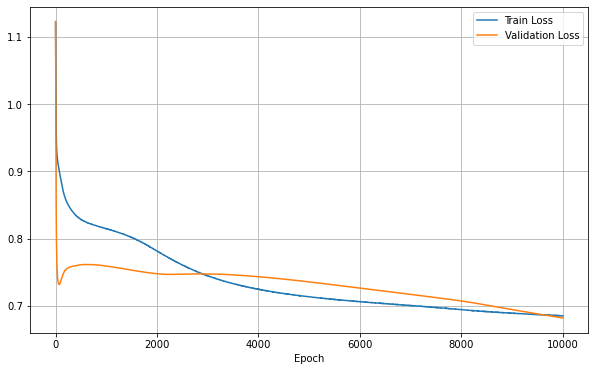

In [113]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(train_loss_all, label='Train Loss')
ax.plot(val_loss_all, label='Validation Loss')
ax.set_xlabel('Epoch')
ax.legend()
ax.grid()
plt.show()

## Testing Set Outputs

In [117]:
test_loss, test_accuracy, test_predictions, test_truth_values = validate(BaseNN, test_loader, device)

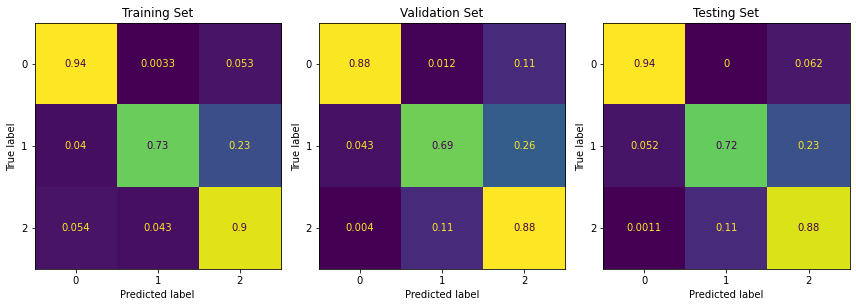

In [120]:
fig, ax = plt.subplots(1,3, figsize=(12,20))
ConfusionMatrixDisplay.from_predictions(train_truth_values, train_predictions, ax = ax[0], normalize='true', colorbar=False)
ConfusionMatrixDisplay.from_predictions(val_truth_values, val_predictions, ax = ax[1], normalize='true', colorbar=False)
ConfusionMatrixDisplay.from_predictions(test_truth_values, test_predictions, ax = ax[2], normalize='true', colorbar=False)

ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')
ax[2].set_title('Testing Set')
plt.tight_layout()
plt.show()

## Saving the Model

In [98]:
filepath = 'good_model_20ke_4e3_noschedule_balanced_300'
torch.save(BaseNN.state_dict(), filepath)